# Model Training Visualization

This notebook visualizes the training results for all models trained in the CV1 Final Lab Part 2.

## Contents
1. Setup and Imports
2. TensorBoard Log Visualization
3. Optuna Hyperparameter Study Visualization
4. Model Comparison and Analysis

## 1. Setup and Imports

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    !pip install seaborn as sns
from tensorboard.backend.event_processing import event_accumulator
import joblib
import optuna


# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully')


Libraries imported successfully


## 2. TensorBoard Log Visualization

This section reads the TensorBoard event files and visualizes the training curves for all models.


In [23]:
def find_latest_event_file(log_dir):
    """Find the most recent event file in a directory."""
    event_files = [f for f in os.listdir(log_dir) if f.startswith('events.out.tfevents')]
    if not event_files:
        return None
    # Sort by modification time and return the most recent
    event_files_with_time = [(f, os.path.getmtime(os.path.join(log_dir, f))) for f in event_files]
    latest_file = max(event_files_with_time, key=lambda x: x[1])[0]
    return os.path.join(log_dir, latest_file)

def read_tensorboard_logs(log_dir):
    """Read TensorBoard event files from a directory (only the latest file)."""
    # Find the latest event file to avoid reading multiple training runs
    latest_event = find_latest_event_file(log_dir)
    if not latest_event:
        print(f"No event files found in {log_dir}")
        return {}
    
    ea = event_accumulator.EventAccumulator(latest_event)
    ea.Reload()
    
    data = {}
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        data[tag] = {
            'steps': [e.step for e in events],
            'values': [e.value for e in events]
        }
    return data

def find_latest_run(base_dir, model_name):
    """Find the latest run directory for a given model."""
    model_dir = os.path.join(base_dir, model_name.lower())
    if not os.path.exists(model_dir):
        return None
    runs = sorted(os.listdir(model_dir))
    if not runs:
        return None
    return os.path.join(model_dir, runs[-1])

# Read logs for all models
base_log_dir = 'runs'
models = ['twolayernet', 'convnet', 'extendedtwolayernet', 'extendedconvnet']
model_logs = {}

for model in models:
    log_dir = find_latest_run(base_log_dir, model)
    if log_dir:
        print(f"Reading logs for {model} from {log_dir}")
        model_logs[model] = read_tensorboard_logs(log_dir)
    else:
        print(f"No logs found for {model}")

print(f"\nLoaded logs for {len(model_logs)} models")


Reading logs for twolayernet from runs/twolayernet/2025-10-25_00-18-29
Reading logs for convnet from runs/convnet/2025-10-25_00-18-29
Reading logs for extendedtwolayernet from runs/extendedtwolayernet/2025-10-25_00-18-29
Reading logs for extendedconvnet from runs/extendedconvnet/2025-10-25_00-18-29

Loaded logs for 4 models


### 2.1 Training and Validation Loss Curves


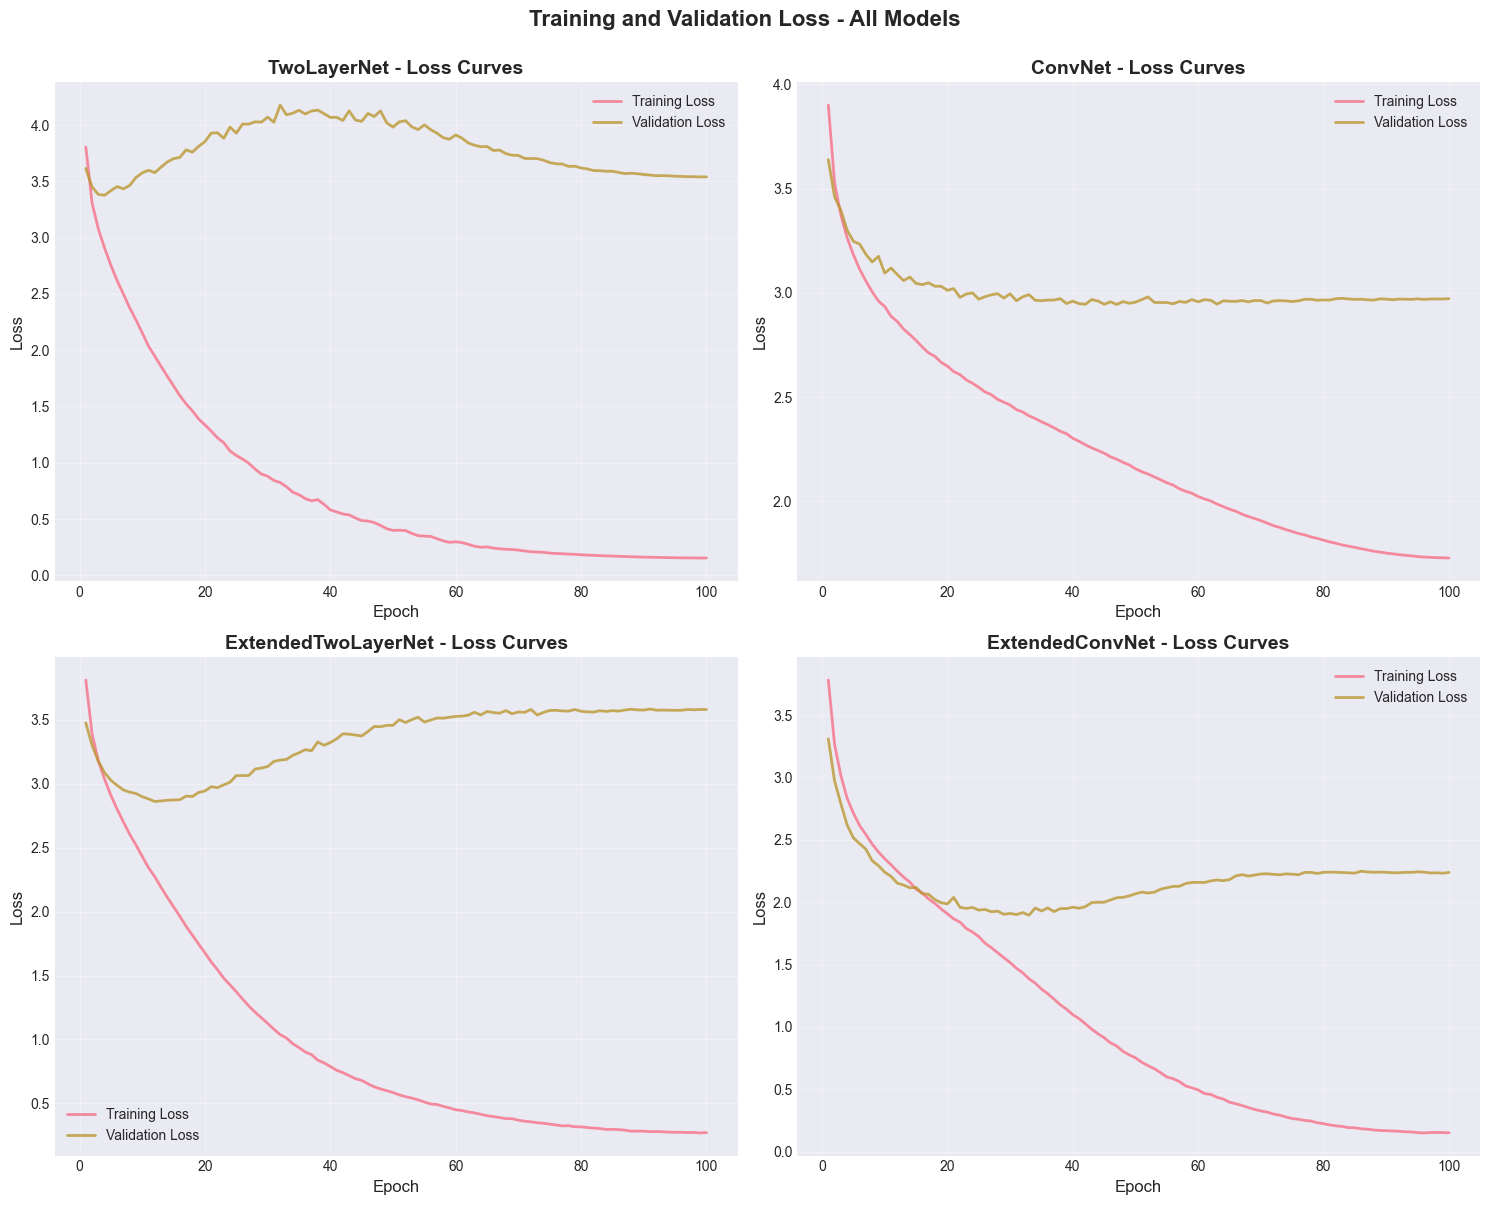

Figure saved as 'all_models_loss_curves.png'


In [ ]:
# Plot training loss for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

model_names = {
    'twolayernet': 'TwoLayerNet',
    'convnet': 'ConvNet',
    'extendedtwolayernet': 'ExtendedTwoLayerNet',
    'extendedconvnet': 'ExtendedConvNet'
}

for idx, (model_key, logs) in enumerate(model_logs.items()):
    ax = axes[idx]
    
    # Plot training loss
    if 'Train/Loss' in logs:
        train_data = logs['Train/Loss']
        ax.plot(train_data['steps'], train_data['values'], 
                label='Training Loss', linewidth=2, alpha=0.8)
    
    # Plot validation loss if available
    if 'Val/Loss' in logs:
        val_data = logs['Val/Loss']
        ax.plot(val_data['steps'], val_data['values'], 
                label='Validation Loss', linewidth=2, alpha=0.8)
        
        # Find and mark the best (minimum) validation loss
        best_val_loss = min(val_data['values'])
        best_val_epoch = val_data['steps'][val_data['values'].index(best_val_loss)]
        ax.scatter([best_val_epoch], [best_val_loss], color='red', s=150, 
                   marker='*', zorder=5, label=f'Best: {best_val_loss:.4f}')
        ax.axhline(y=best_val_loss, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(f'{model_names.get(model_key, model_key)} - Loss Curves', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Training and Validation Loss - All Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('all_models_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'all_models_loss_curves.png'")


### 2.2 Training and Validation Accuracy Curves


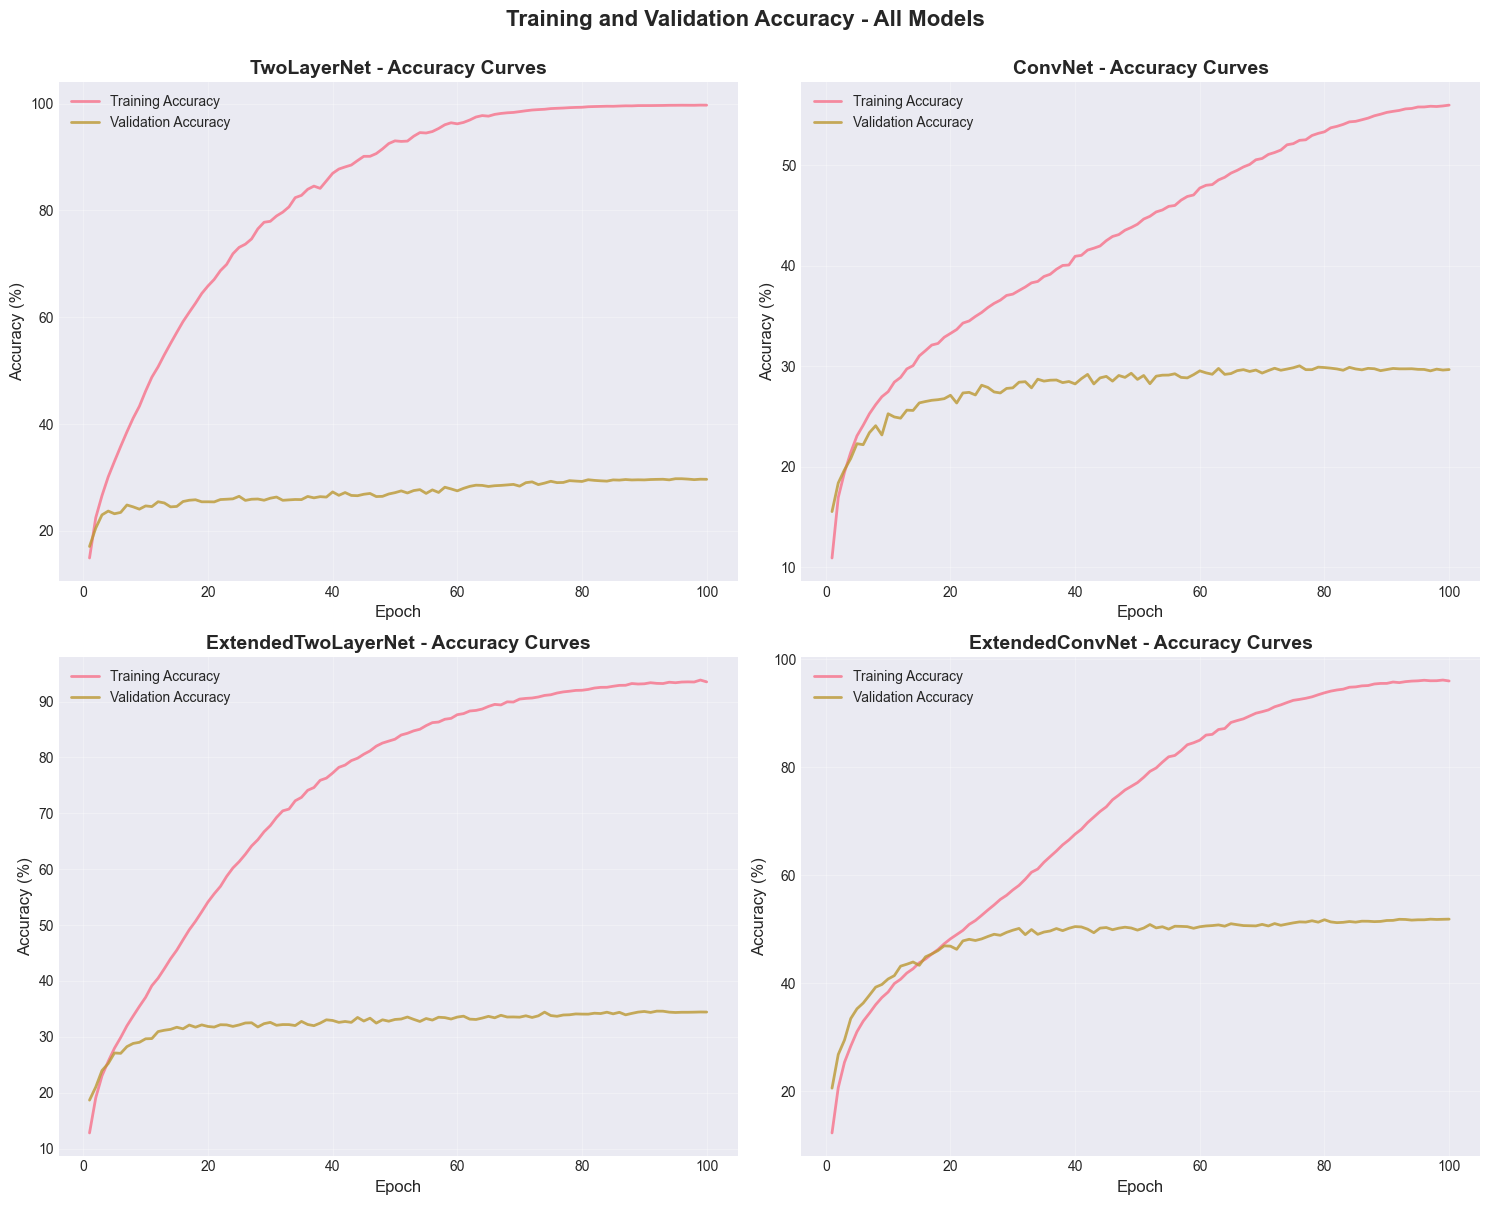

Figure saved as 'all_models_accuracy_curves.png'


In [ ]:
# Plot accuracy for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, (model_key, logs) in enumerate(model_logs.items()):
    ax = axes[idx]
    
    # Plot training accuracy
    if 'Train/Accuracy' in logs:
        train_data = logs['Train/Accuracy']
        ax.plot(train_data['steps'], train_data['values'], 
                label='Training Accuracy', linewidth=2, alpha=0.8)
    
    # Plot validation accuracy if available
    if 'Val/Accuracy' in logs:
        val_data = logs['Val/Accuracy']
        ax.plot(val_data['steps'], val_data['values'], 
                label='Validation Accuracy', linewidth=2, alpha=0.8)
        
        # Find and mark the best validation accuracy
        best_val_acc = max(val_data['values'])
        best_val_epoch = val_data['steps'][val_data['values'].index(best_val_acc)]
        ax.scatter([best_val_epoch], [best_val_acc], color='red', s=150, 
                   marker='*', zorder=5, label=f'Best: {best_val_acc:.2f}%')
        ax.axhline(y=best_val_acc, color='red', linestyle='--', alpha=0.3, linewidth=1)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(f'{model_names.get(model_key, model_key)} - Accuracy Curves', 
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Training and Validation Accuracy - All Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('all_models_accuracy_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'all_models_accuracy_curves.png'")


## 3. Optuna Hyperparameter Study Visualization

This section visualizes the hyperparameter optimization results from Optuna studies.


In [26]:
# Load Optuna studies
optuna_dir = 'optuna_studies'
study_files = {
    'TwoLayerNet': 'twolayernet_20251015_220546.pkl',
    'ConvNet': 'convnet_20251015_224750.pkl',
    'ExtendedTwoLayerNet': 'extendedtwolayernet_20251016_031355.pkl',
    'ExtendedConvNet': 'extendedconvnet_20251016_201838.pkl'
}

studies = {}
for model_name, pkl_file in study_files.items():
    pkl_path = os.path.join(optuna_dir, pkl_file)
    if os.path.exists(pkl_path):
        print(f"Loading study for {model_name} from {pkl_path}")
        studies[model_name] = joblib.load(pkl_path)
    else:
        print(f"Study file not found: {pkl_path}")

print(f"\nLoaded {len(studies)} Optuna studies")


Loading study for TwoLayerNet from optuna_studies/twolayernet_20251015_220546.pkl
Loading study for ConvNet from optuna_studies/convnet_20251015_224750.pkl
Loading study for ExtendedTwoLayerNet from optuna_studies/extendedtwolayernet_20251016_031355.pkl
Loading study for ExtendedConvNet from optuna_studies/extendedconvnet_20251016_201838.pkl

Loaded 4 Optuna studies


### 3.1 Optimization History


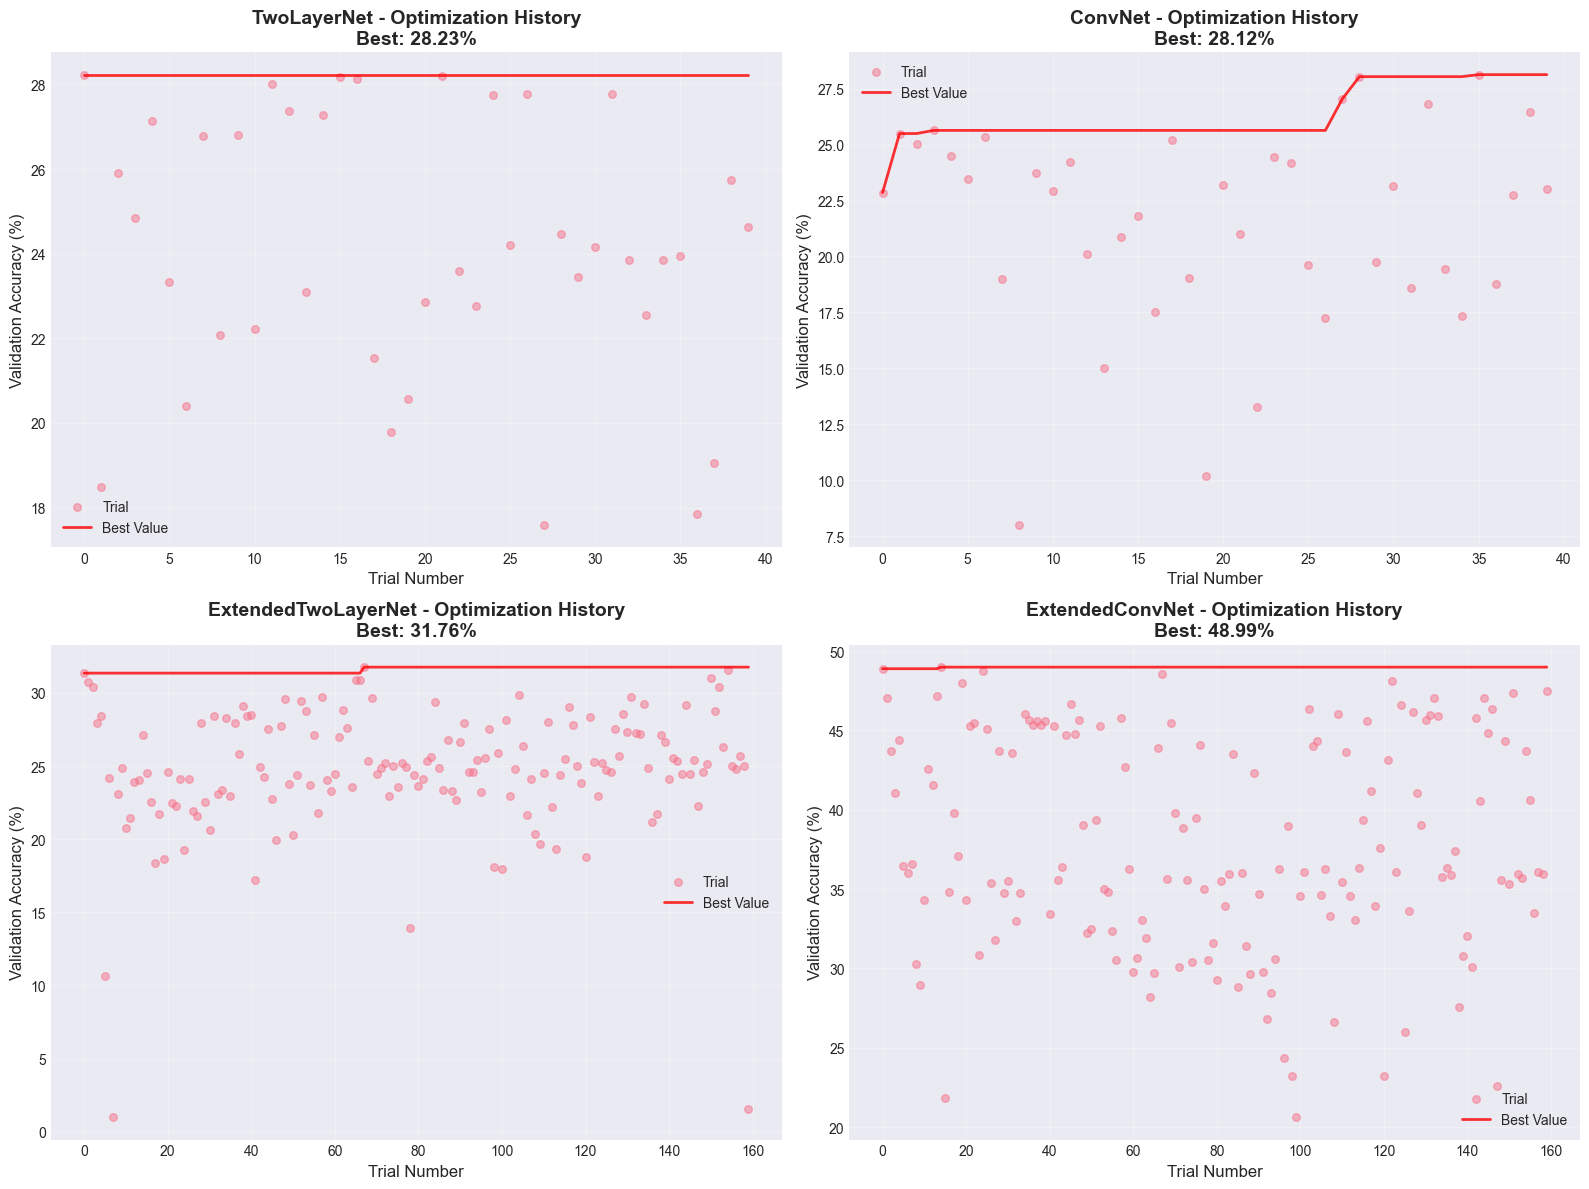

Figure saved as 'optuna_optimization_history.png'


In [27]:
# Plot optimization history for all studies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (model_name, study) in enumerate(studies.items()):
    ax = axes[idx]
    
    # Get trial values
    trial_values = [t.value for t in study.trials if t.value is not None]
    trial_numbers = [t.number for t in study.trials if t.value is not None]
    
    # Plot all trials
    ax.scatter(trial_numbers, trial_values, alpha=0.5, s=30, label='Trial')
    
    # Plot best value line
    best_values = []
    current_best = -np.inf
    for val in trial_values:
        current_best = max(current_best, val)
        best_values.append(current_best)
    
    ax.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best Value', alpha=0.8)
    
    ax.set_xlabel('Trial Number', fontsize=12)
    ax.set_ylabel('Validation Accuracy (%)', fontsize=12)
    ax.set_title(f'{model_name} - Optimization History\nBest: {study.best_value:.2f}%', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('optuna_optimization_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'optuna_optimization_history.png'")


### 3.2 Best Hyperparameters Summary


In [28]:
# Print best hyperparameters for each model
print("\n" + "="*80)
print("BEST HYPERPARAMETERS FOR EACH MODEL")
print("="*80)

for model_name, study in studies.items():
    print(f"\n{model_name}:")
    print(f"  Best Trial: #{study.best_trial.number}")
    print(f"  Best Validation Accuracy: {study.best_value:.2f}%")
    print(f"  Best Parameters:")
    for param, value in study.best_params.items():
        if isinstance(value, float):
            print(f"    {param}: {value:.6f}")
        else:
            print(f"    {param}: {value}")
    print("-"*80)

print("="*80)



BEST HYPERPARAMETERS FOR EACH MODEL

TwoLayerNet:
  Best Trial: #0
  Best Validation Accuracy: 28.23%
  Best Parameters:
    lr: 0.000561
    weight_decay: 0.000797
    optimizer_type: adam
    scheduler_type: cosine
    batch_size: 256
    hidden_size: 2048
--------------------------------------------------------------------------------

ConvNet:
  Best Trial: #35
  Best Validation Accuracy: 28.12%
  Best Parameters:
    lr: 0.004238
    weight_decay: 0.000734
    optimizer_type: adam
    scheduler_type: cosine
    batch_size: 256
--------------------------------------------------------------------------------

ExtendedTwoLayerNet:
  Best Trial: #67
  Best Validation Accuracy: 31.76%
  Best Parameters:
    lr: 0.000244
    weight_decay: 0.000775
    optimizer_type: adam
    scheduler_type: cosine
    batch_size: 128
    h1: 1536
    h2: 768
    h3: 384
    dropout: 0.164673
--------------------------------------------------------------------------------

ExtendedConvNet:
  Best Trial

## 4. Model Comparison

Final comparison of all models showing the best validation accuracies achieved.


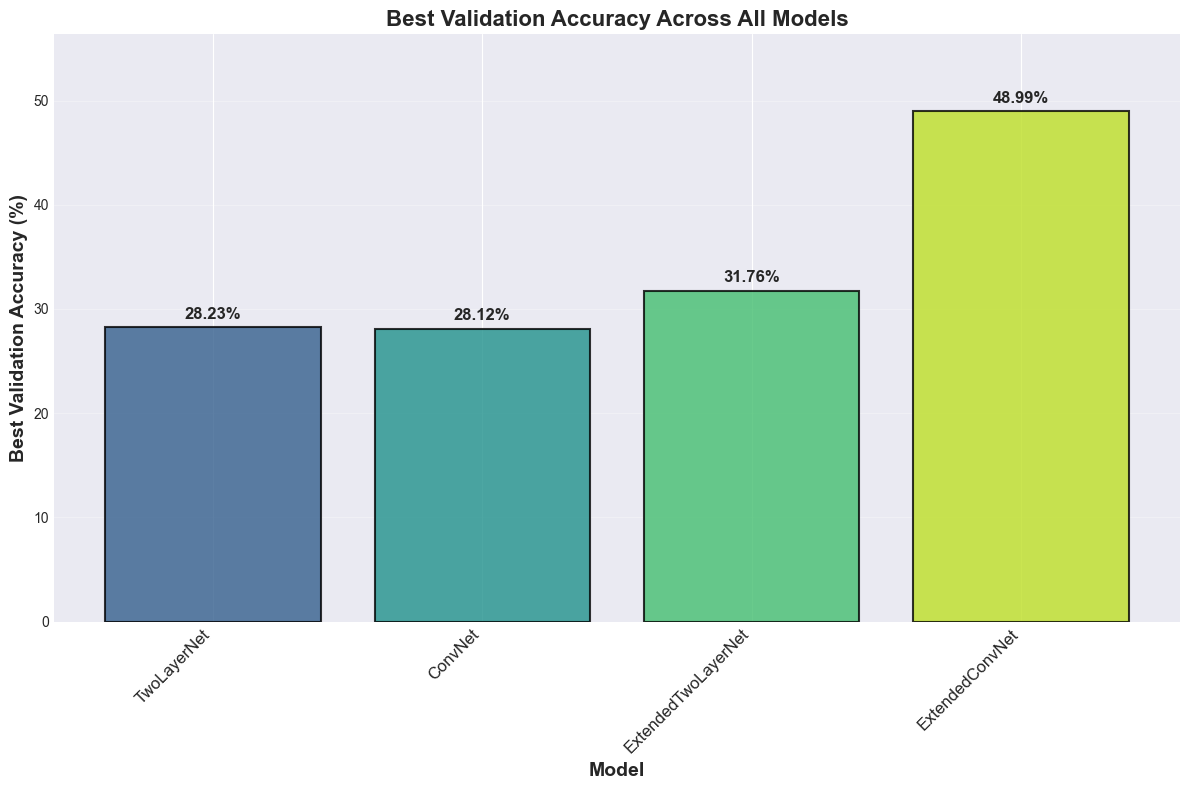

Figure saved as 'model_best_accuracy_comparison.png'

All visualizations completed successfully!


In [29]:
# Visualize best validation accuracy for all models
fig, ax = plt.subplots(figsize=(12, 8))

model_names_list = list(studies.keys())
best_accs = [studies[m].best_value for m in model_names_list]

# Create bar plot
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(model_names_list)))
bars = ax.bar(range(len(model_names_list)), best_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on top of bars
for i, (bar, acc) in enumerate(zip(bars, best_accs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Model', fontsize=14, fontweight='bold')
ax.set_ylabel('Best Validation Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Best Validation Accuracy Across All Models', fontsize=16, fontweight='bold')
ax.set_xticks(range(len(model_names_list)))
ax.set_xticklabels(model_names_list, rotation=45, ha='right', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(best_accs) * 1.15)

plt.tight_layout()
plt.savefig('model_best_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'model_best_accuracy_comparison.png'")
print("\nAll visualizations completed successfully!")


In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing import event_accumulator
import joblib
import optuna

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries imported successfully')

Libraries imported successfully
